In [1]:
import pandas as pd
import csv
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
from sklearn.linear_model import LinearRegression

# Format Eye Data

## Find and Load Tracking, Logs, and Stimulus Data

In [3]:
directory_path = r"C:\Users\fenklab\Desktop\Smooth Tracking Entry\output"
output_directory_path = r"C:\Users\fenklab\Desktop\Smooth Tracking Entry\Cleaned Data"
Ref_stimulus_path = r"C:\Users\fenklab\Desktop\Smooth Tracking Entry\RefStimulus.csv"

fly = 'Yakuba1901_6'
output_files = os.listdir(os.path.join(directory_path, fly))

path_raw_LE = ""
path_raw_RE = ""
path_raw_Stimulus = ""
path_Log = ""
fly_log = {}

# Iterate through the list and extract the fly's IDs
for item in output_files:
    if item.find("csv") != -1:
        if item.find("Left") != -1:
            path_raw_LE = os.path.join(directory_path, fly, item)
        elif item.find("Right") != -1:
            path_raw_RE = os.path.join(directory_path, fly, item)
        elif item.find("stimulus_log") != -1:
            path_raw_Stimulus = os.path.join(directory_path, fly, item)
    elif item.find("txt") != -1:
        path_Log = os.path.join(directory_path, fly, item)
        with open(path_Log, 'r') as file:
            for line in file:
                line = line.strip()
                if line:
                    key, value = map(str.strip, line.split(': '))
                    fly_log[key] = value

df_LE_raw = pd.read_csv (path_raw_LE)
df_RE_raw = pd.read_csv(path_raw_RE)
df_Stimulus = pd.read_csv (path_raw_Stimulus)

## Check if recording ran through smoothly

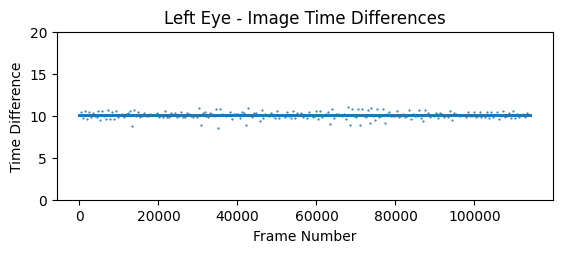

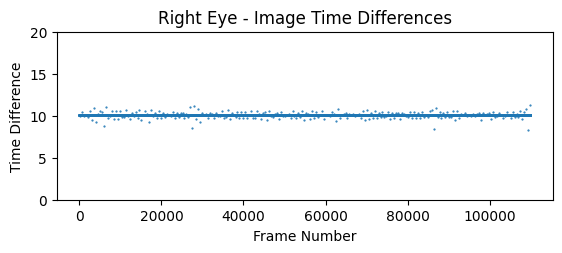

In [4]:
def FrameRateCheck(df_func, name='' , y_lower=0, y_upper=20):
    # Convert to numpy array
    arr = np.array(df_func['aquisition_time'])
    
    # Calculate the differences between consecutive elements in the 'image_time' array
    arr_diff = np.diff(arr)
    
    # Create and display the plot
    plt.scatter(df_func['frame_id'][:-1], arr_diff, s=0.3)
    plt.ylim([y_lower, y_upper])
    plt.title(f'{name} - Image Time Differences')
    plt.xlabel('Frame Number')
    plt.ylabel('Time Difference')
    return plt.show()

plt.subplot(2,1, 2)
FrameRateCheck(df_LE_raw, name="Left Eye")

plt.subplot(2,1, 1)
FrameRateCheck(df_RE_raw, name="Right Eye")

## Remove Outliers in Pupil Positions

remove :0
remove :0


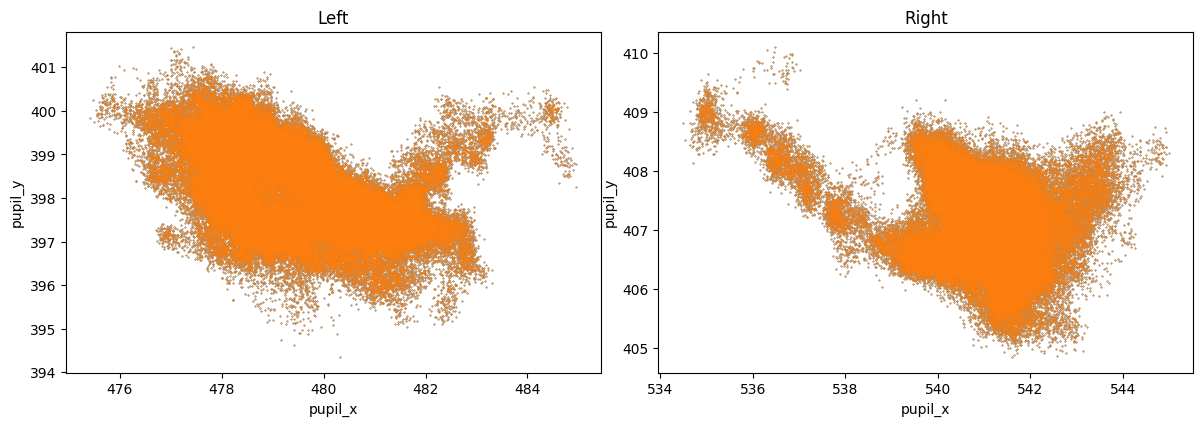

In [103]:
outlier_treshold_Left = 8
outlier_treshold_Right = 8

def remove_outliers(df, threshold=2):
    # Calculate Z-scores for each data point in the DataFrame
    z_scores = np.abs((df[['pupil_x','pupil_y']] - df[['pupil_x','pupil_y']].mean()) / df[['pupil_x','pupil_y']].std())

    # Create a mask to identify rows with any Z-score greater than the threshold
    mask = (z_scores < threshold).all(axis=1)
    print(f"remove :{df.shape[0] - df[mask].shape[0]}")
    # Return the DataFrame with outliers removed
    return df[mask]

def config_EyePositionSubPlot(axs, df, x_axis, y_axis, title):
    axs.scatter(df[x_axis], df[y_axis], s=0.1)
    axs.title.set_text(title)
    axs.set_xlabel(x_axis)
    axs.set_ylabel(y_axis)

df_LE = remove_outliers(df_LE_raw, outlier_treshold_Left).copy()
df_RE = remove_outliers(df_RE_raw, outlier_treshold_Right).copy()

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=False)
plt.tight_layout()
plt.subplots_adjust(hspace=0)

i = 0
config_EyePositionSubPlot(axs[i], df_LE_raw, x_axis='pupil_x', y_axis='pupil_y', title='raw')
config_EyePositionSubPlot(axs[i], df_LE, x_axis='pupil_x', y_axis='pupil_y', title='Left')

i = 1
config_EyePositionSubPlot(axs[i], df_RE_raw, x_axis='pupil_x', y_axis='pupil_y', title='raw')
config_EyePositionSubPlot(axs[i], df_RE, x_axis='pupil_x', y_axis='pupil_y', title='Right')

plt.show()

fly_log['Outlier_Treshold_Left'] = outlier_treshold_Left
fly_log['Outlier_Treshold_Right'] = outlier_treshold_Right

# Make Time Records Relative to the Start of Stimulus

In [104]:
first_loop = df_Stimulus[(df_Stimulus['Event'] == 'loop') & (df_Stimulus['ID'] == 0)]
stimulus_start = first_loop['AbsoluteStart'].iloc[0]
stimulus_start *= 1000
print('stimulus_start')
print(stimulus_start)
fly_log['Stimulus_Start'] = stimulus_start

df_Stimulus['Start_ms'] = 1000*(df_Stimulus['AbsoluteStart']) - stimulus_start
df_Stimulus['End_ms'] = 1000*(df_Stimulus['AbsoluteEnd']) - stimulus_start
print('df_Stimulus')
print(df_Stimulus.head())

df_LE['time_stimuli'] = df_LE['aquisition_time'] - stimulus_start
print('df_LE')
print(df_LE.head())

df_RE['time_stimuli'] = df_RE['aquisition_time'] - stimulus_start
print('df_RE')
print(df_RE.head())

stimulus_start
1705671708610.0688
df_Stimulus
   Event  ID  AbsoluteStart   AbsoluteEnd   Duration      Start_ms  \
0   side   0   1.705672e+09  1.705672e+09   3.011380   1008.301514   
1   side   1   1.705672e+09  1.705672e+09   3.029608   4035.303223   
2   side   2   1.705672e+09  1.705672e+09   3.027343   7080.536865   
3   side   3   1.705672e+09  1.705672e+09   3.002566  10123.501221   
4  phase   0   1.705672e+09  1.705672e+09  13.126067      0.000000   

         End_ms  
0   4019.681885  
1   7064.910889  
2  10107.880127  
3  13126.067139  
4  13126.067139  
df_LE
   frame_id  aquisition_time  process_duration     pupil_x     pupil_y  \
0         0     1.705672e+12          8.160889  484.580284  399.497536   
1         1     1.705672e+12          8.550781  484.742622  399.351810   
2         2     1.705672e+12          9.186523  484.640350  399.303406   
3         3     1.705672e+12          8.839355  484.659794  399.063179   
4         4     1.705672e+12          8.391113  4

# Tag Tracking Records with Corresponding Stimulus' Stages and Tag Children Stimulus Stages with their Parent Stages

In [105]:
#tag frame with stimulus side
for index, row in df_Stimulus.iterrows():
    event = row['Event']
    ID = row['ID']
    start = row['Start_ms']
    end = row['End_ms']
    stimulus_status = "stimuli_" + event
    time_stimulus_status = "time_" + event

    concerned_LE = (df_LE['time_stimuli'] >= start) & (df_LE['time_stimuli'] < end) 
    df_LE.loc[concerned_LE, stimulus_status] = ID

    concerned_RE = (df_RE['time_stimuli'] >= start) & (df_RE['time_stimuli'] < end) 
    df_RE.loc[concerned_RE, stimulus_status] = ID
    
    if (event == "loop") | (event == "phase"):
        df_LE.loc[concerned_LE, time_stimulus_status] = df_LE.loc[concerned_LE, 'time_stimuli']-start
        df_RE.loc[concerned_RE, time_stimulus_status] = df_RE.loc[concerned_RE, 'time_stimuli']-start
        childrenEvents = (df_Stimulus["Event"] != event) & (df_Stimulus['Start_ms'] >= start) & (df_Stimulus['End_ms'] <= end)
        df_Stimulus.loc[childrenEvents, "Parent_" + event] = ID

df_Stimulus.tail()

Event  ID  AbsoluteStart   AbsoluteEnd   Duration      Start_ms  \
436   side   1   1.705673e+09  1.705673e+09   3.019732  1.092420e+06   
437   side   2   1.705673e+09  1.705673e+09   3.007951  1.095455e+06   
438   side   3   1.705673e+09  1.705673e+09   3.023546  1.098479e+06   
439  phase   3   1.705673e+09  1.705673e+09  13.115582  1.088387e+06   
440   loop  20   1.705673e+09  1.705673e+09  52.401964  1.049100e+06   

           End_ms  Parent_phase  Parent_loop  
436  1.095440e+06           3.0         20.0  
437  1.098463e+06           3.0         20.0  
438  1.101502e+06           3.0         20.0  
439  1.101502e+06           NaN         20.0  
440  1.101502e+06           NaN          NaN

# Rotate along the axis -- align with x axis

Note the pixel cooredinate system is not like the math coordinate system, basically inverted at the y axis

## Plot eye motion summary to decide the best momment to define as horizontal motion tracking  

remove :9283
remove :7075


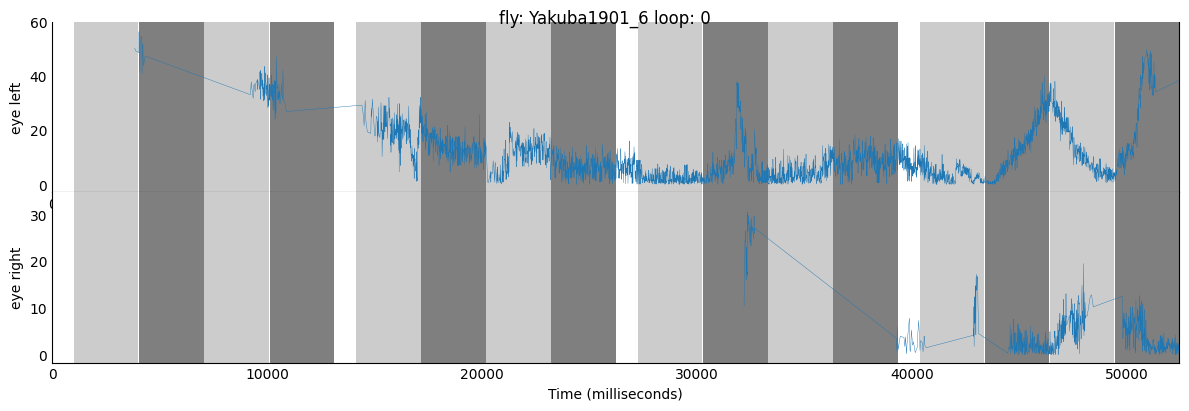

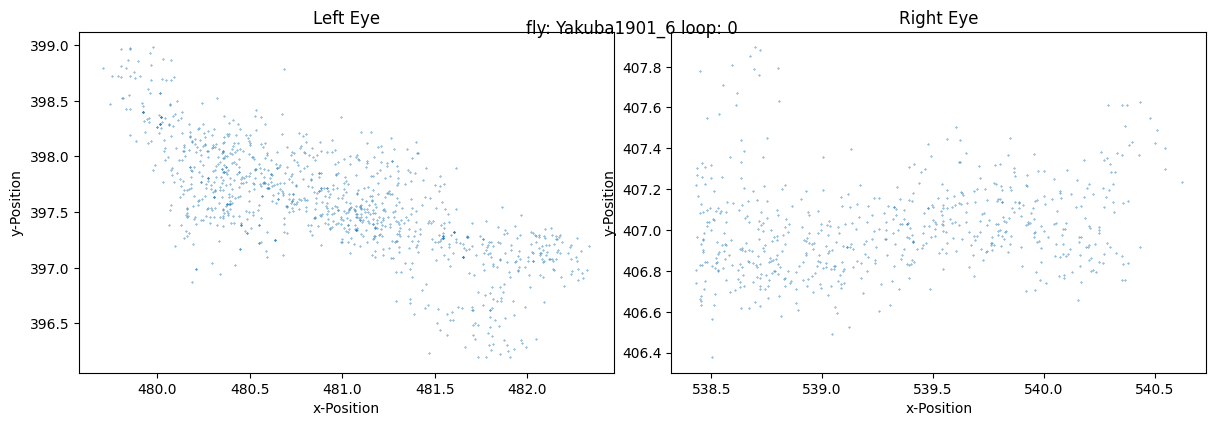

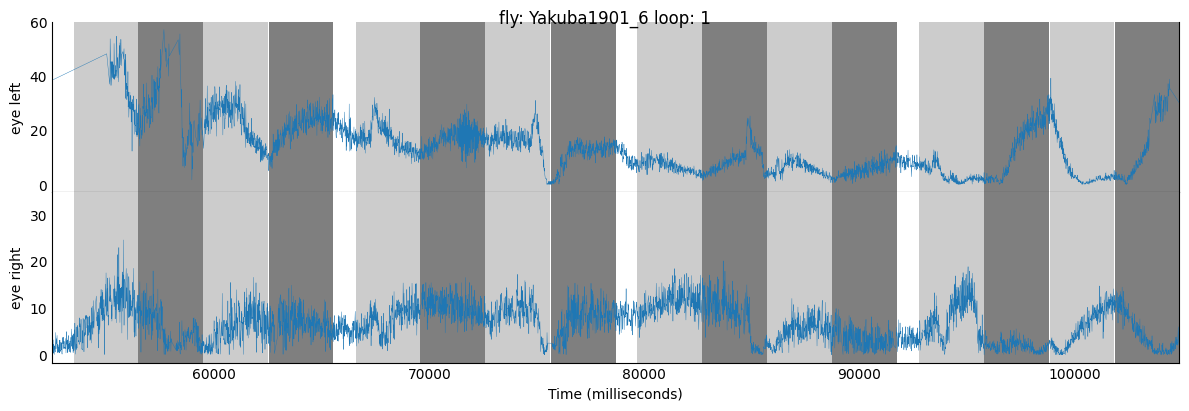

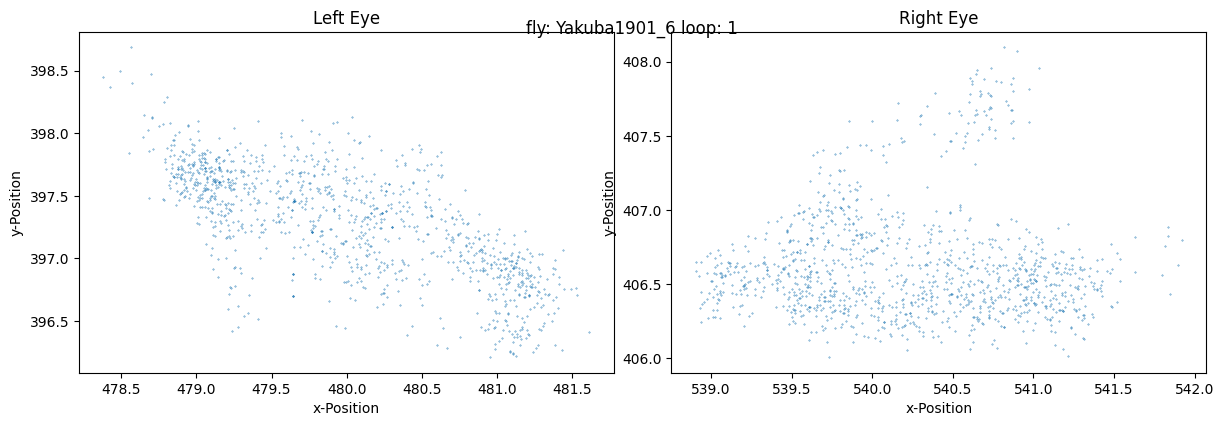

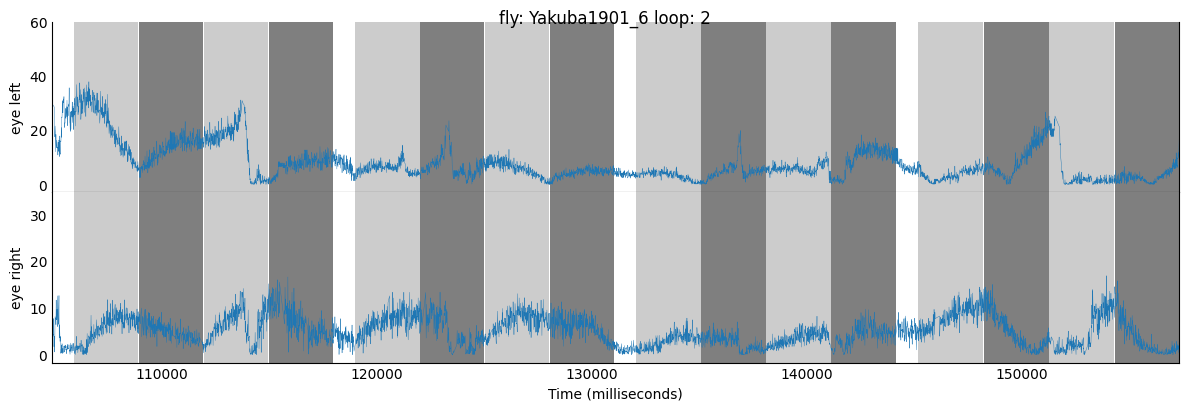

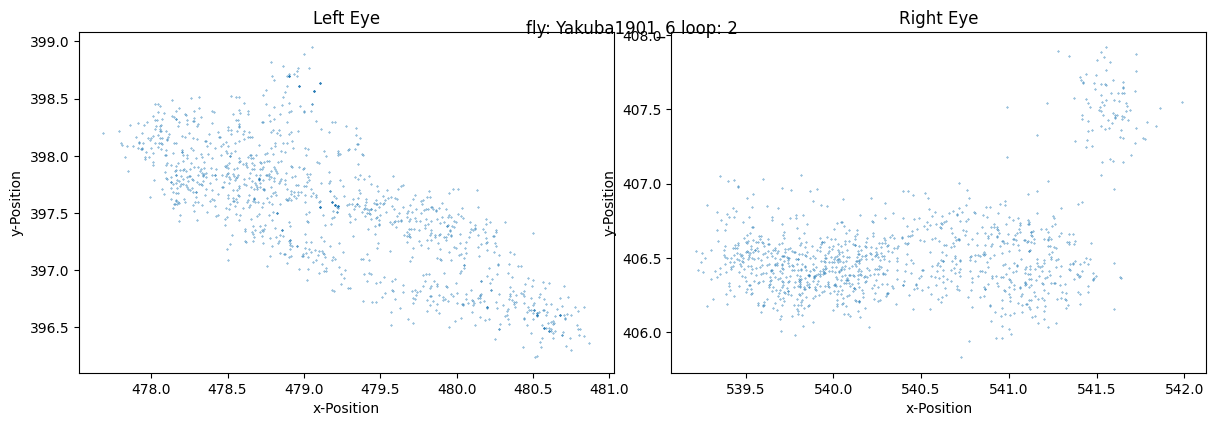

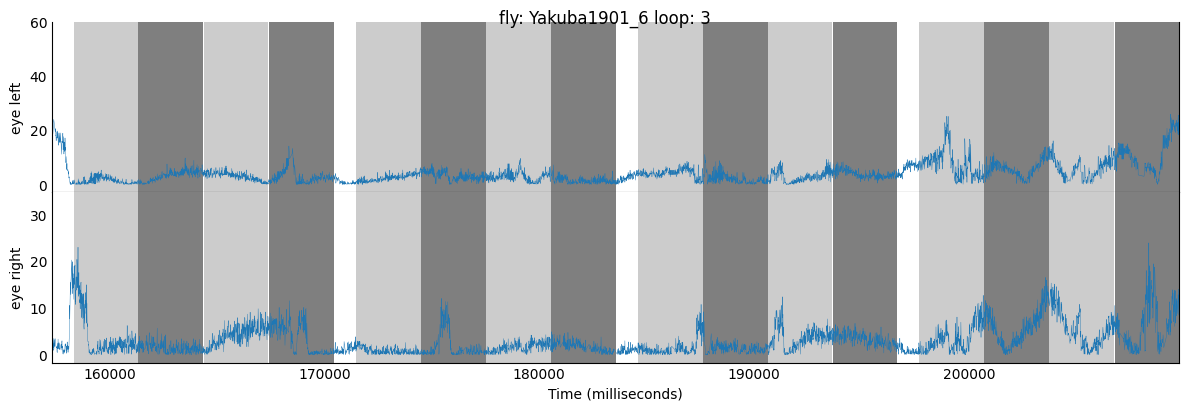

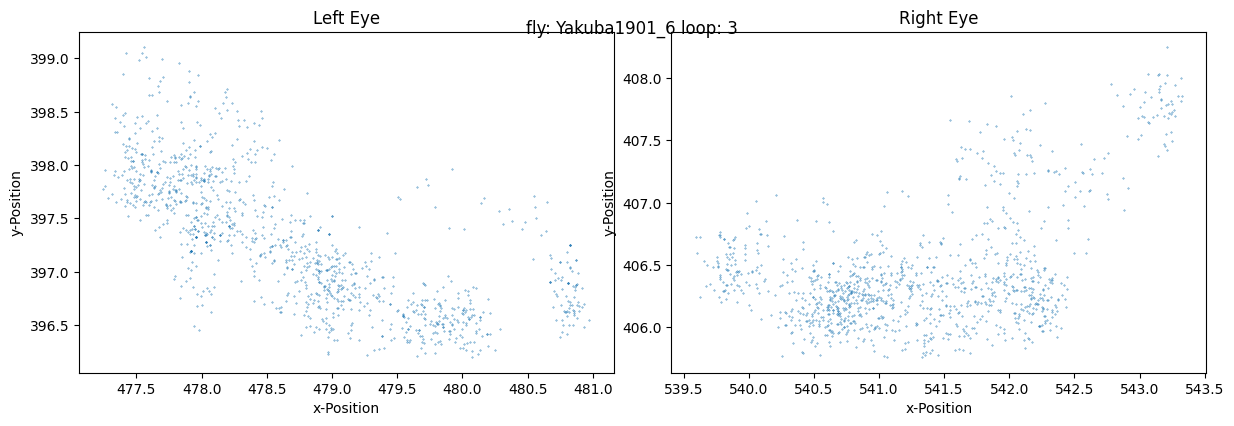

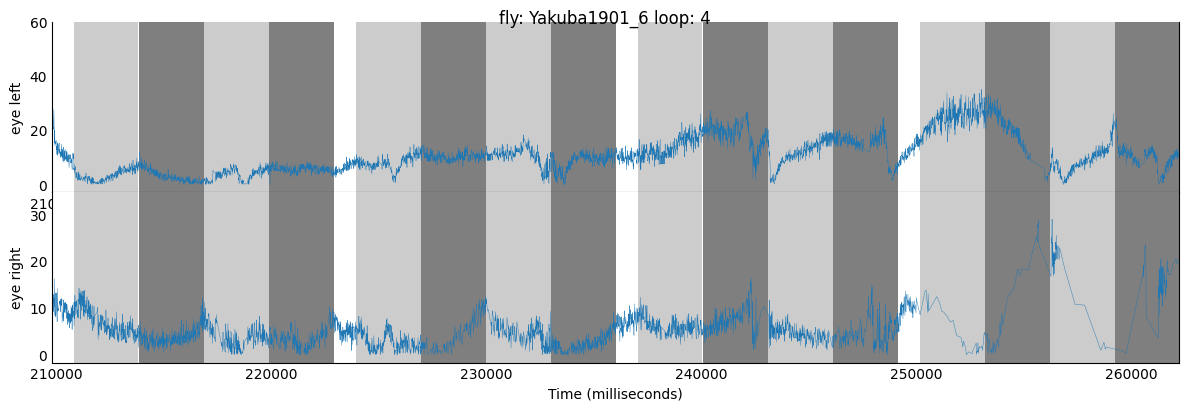

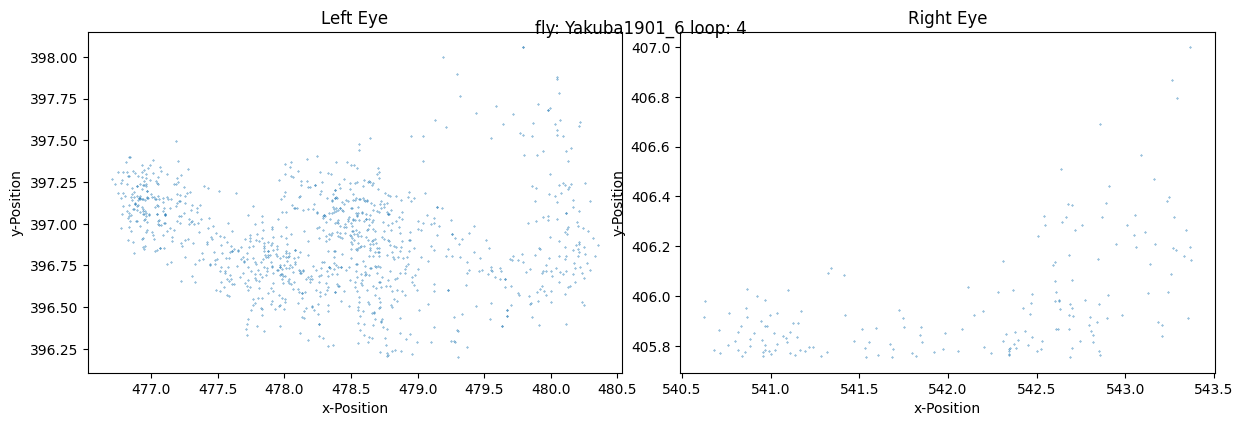

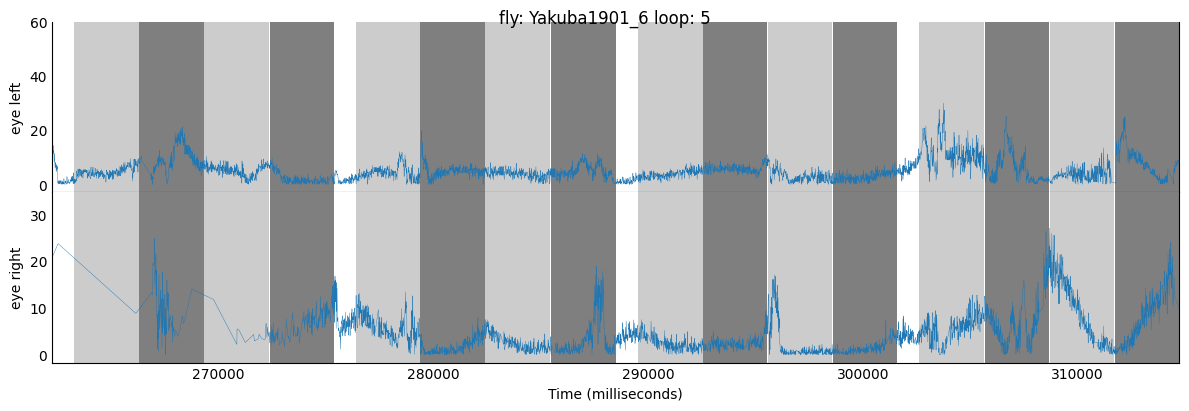

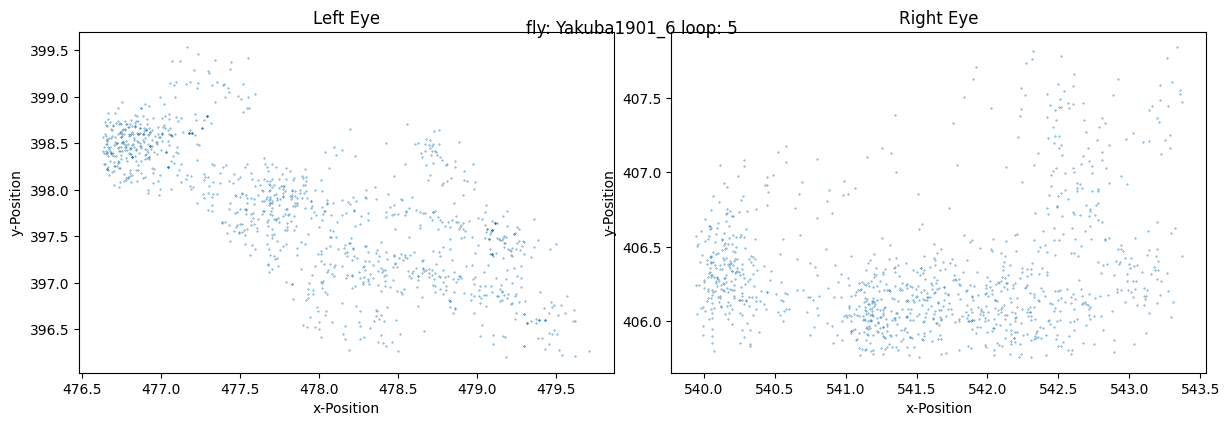

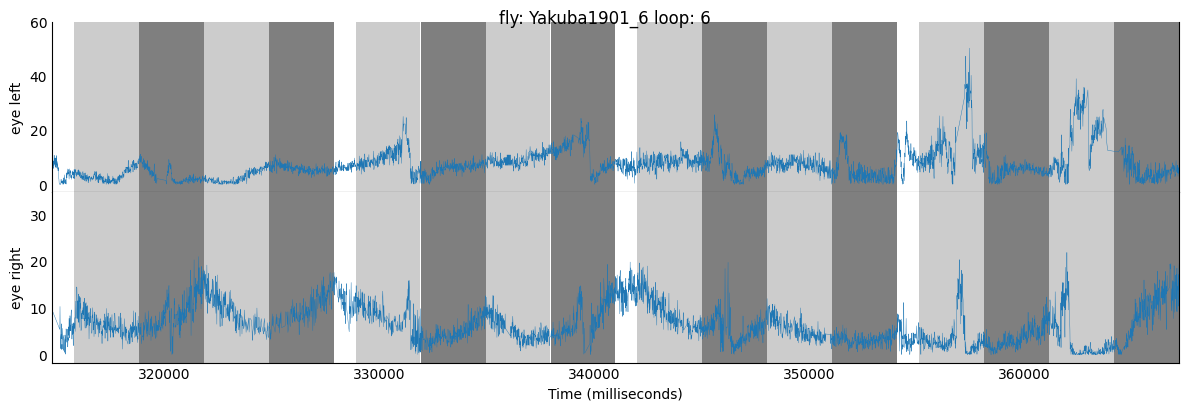

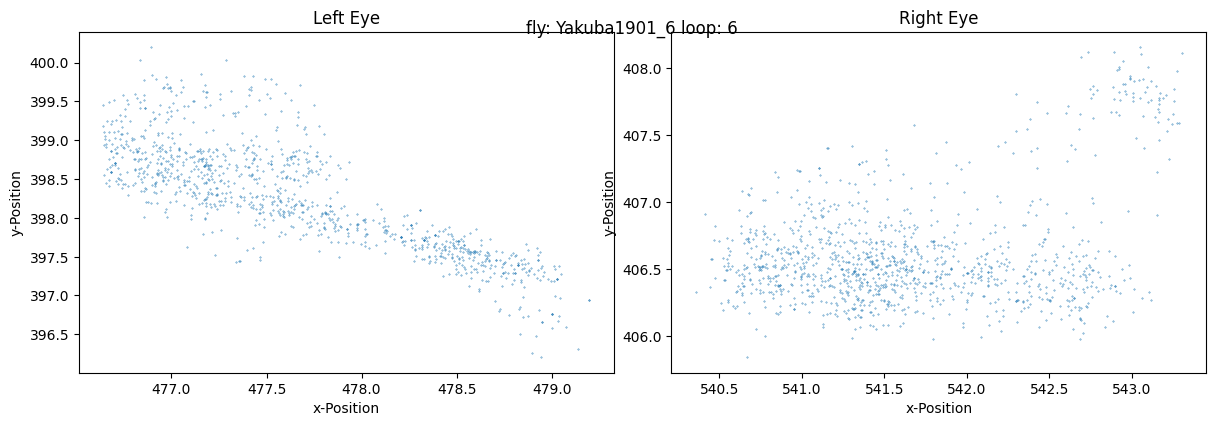

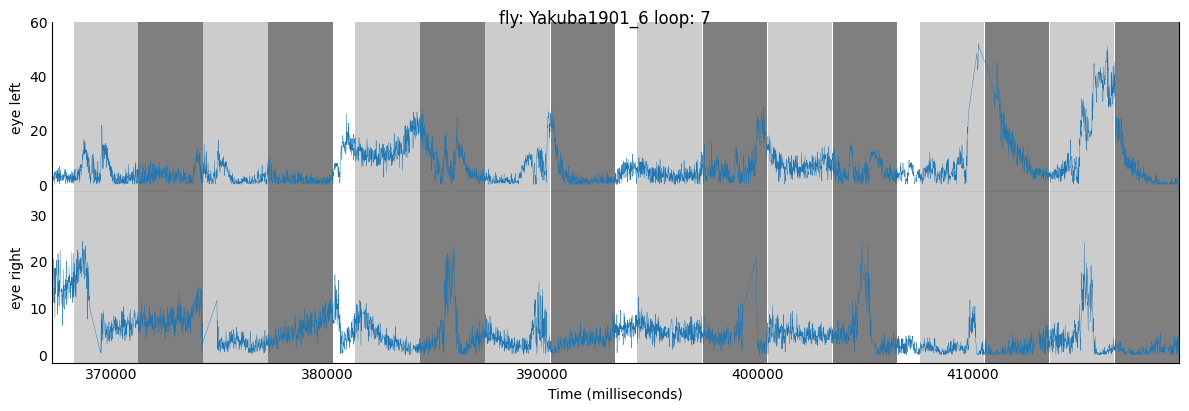

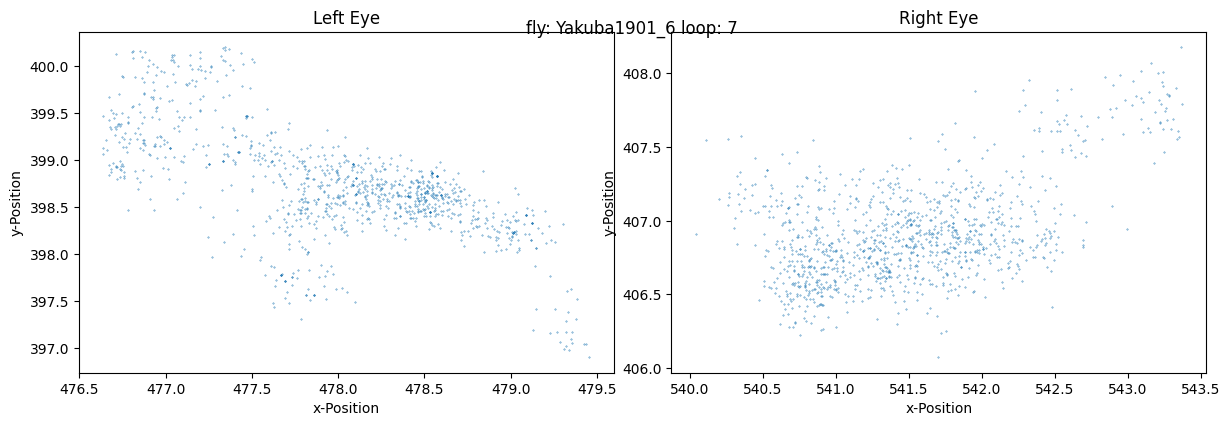

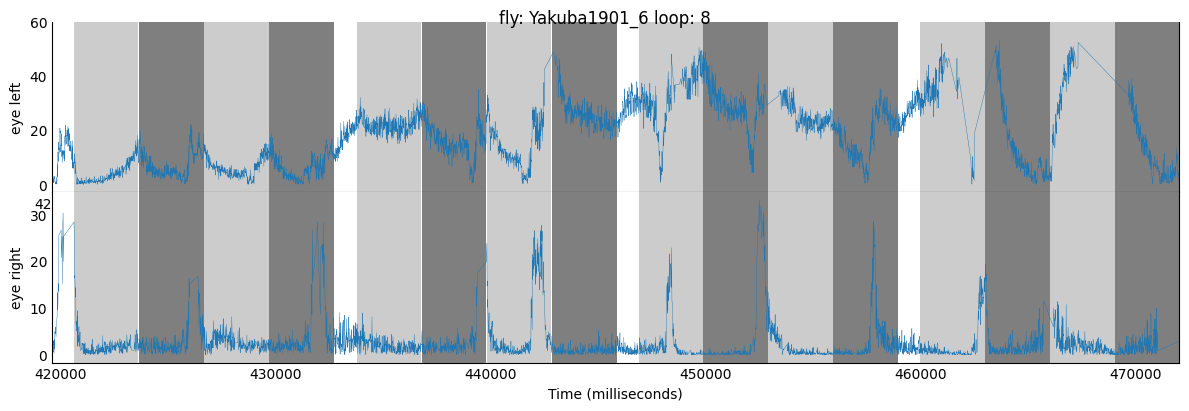

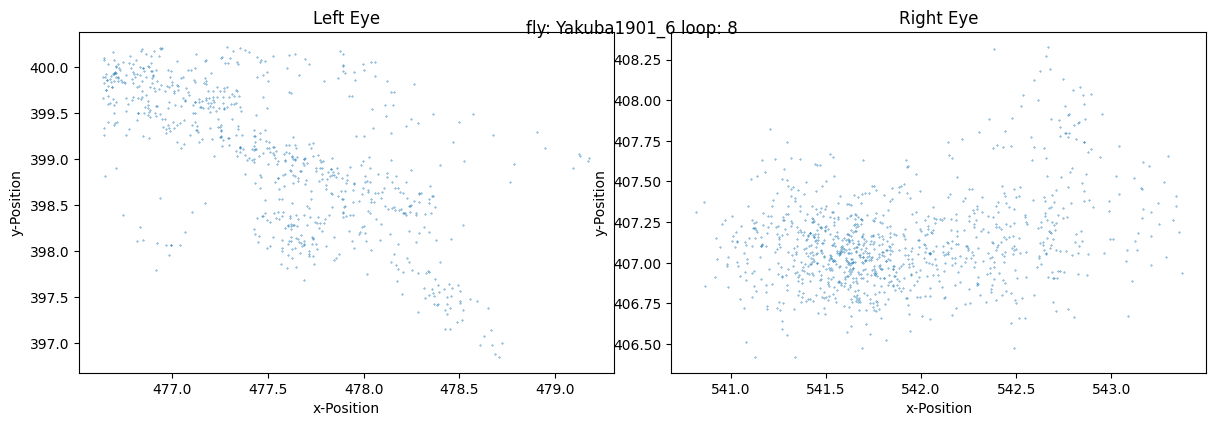

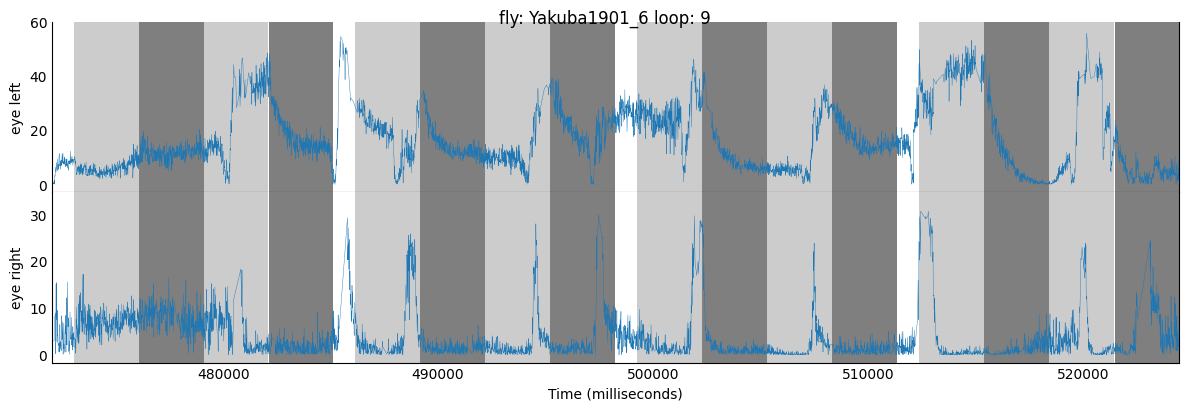

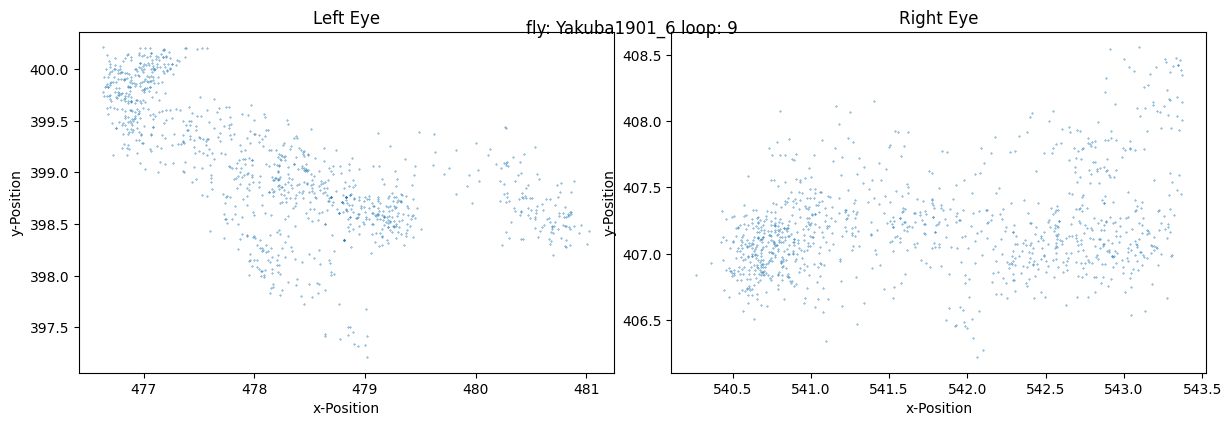

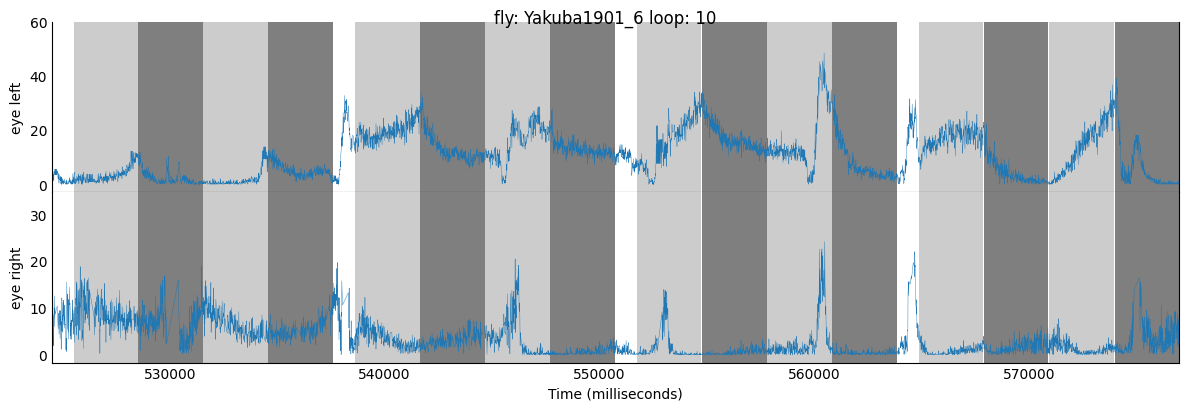

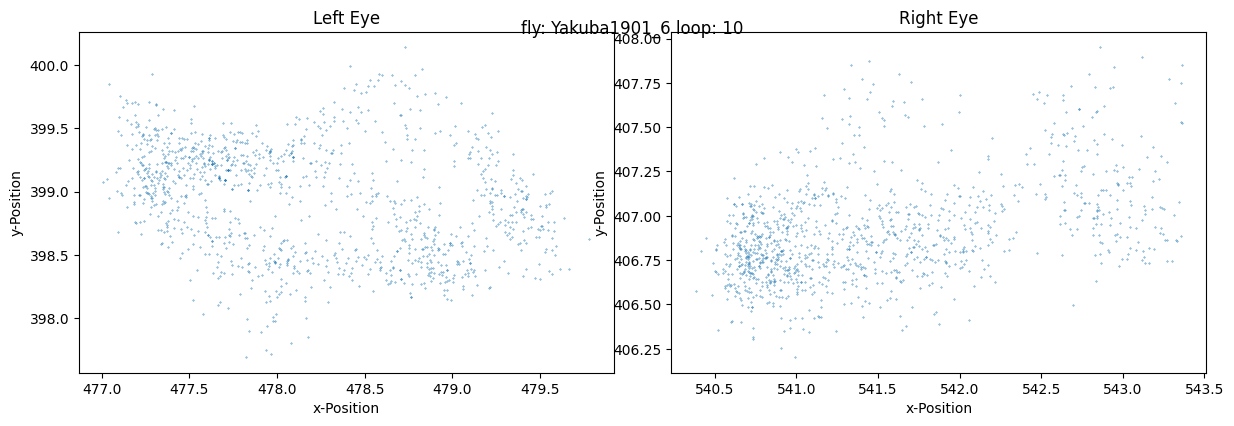

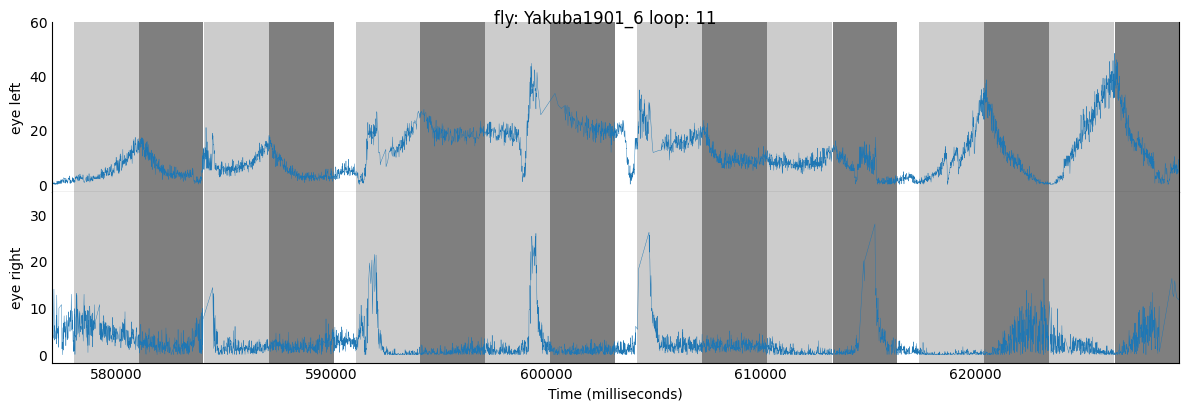

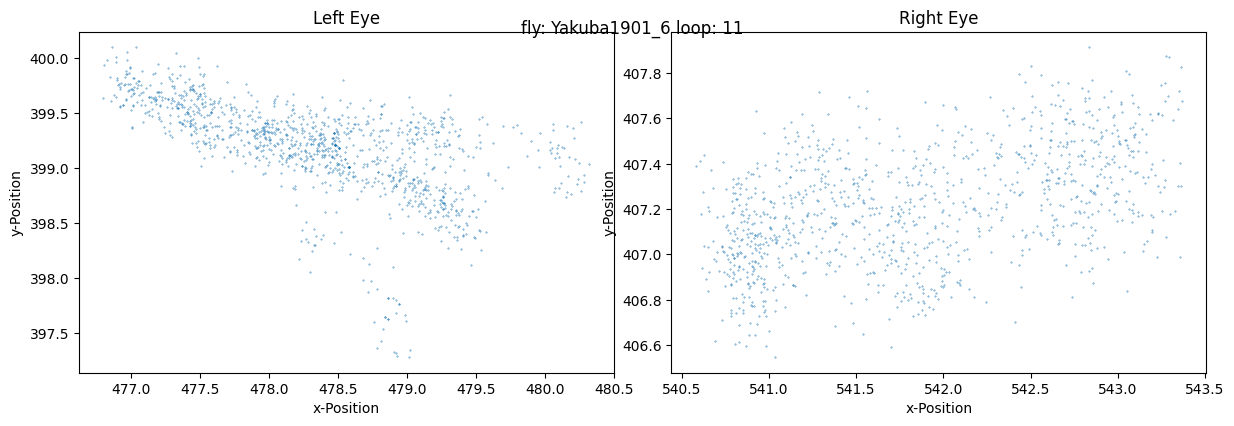

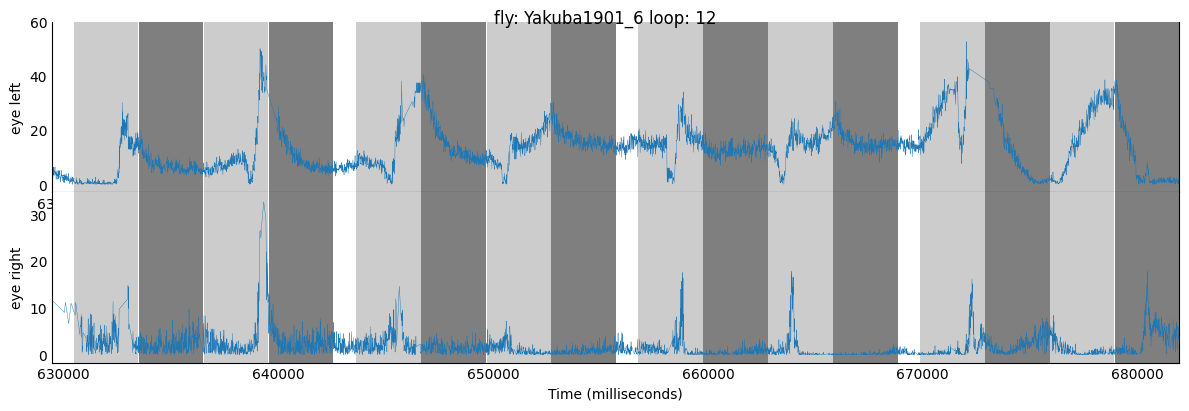

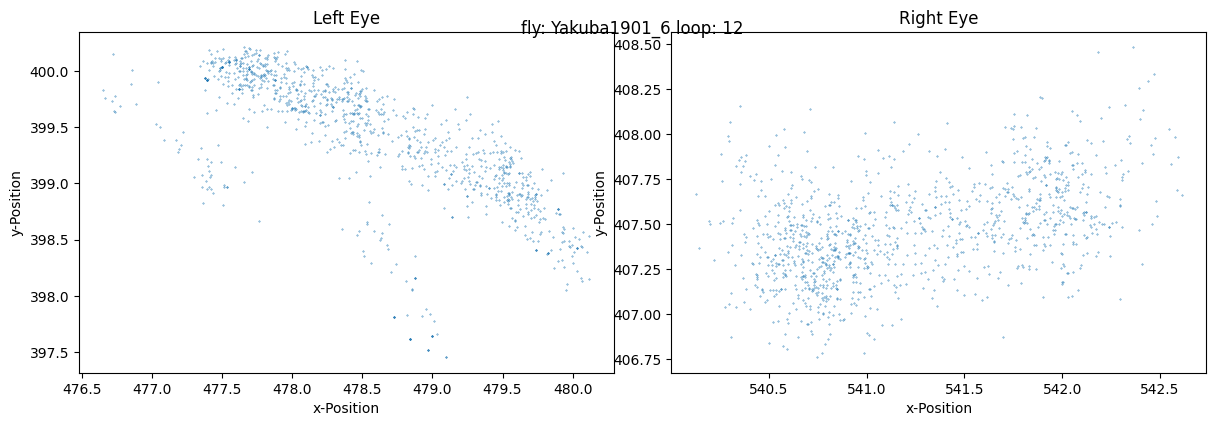

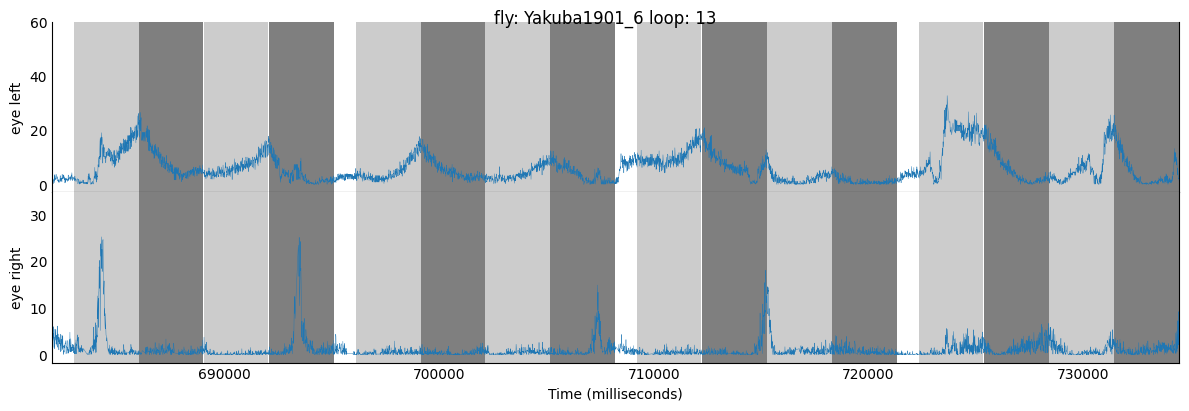

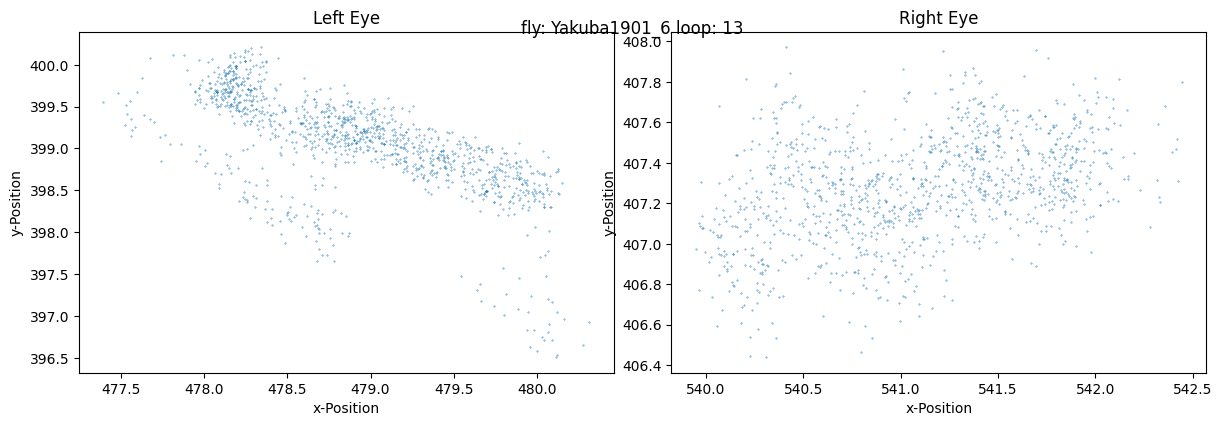

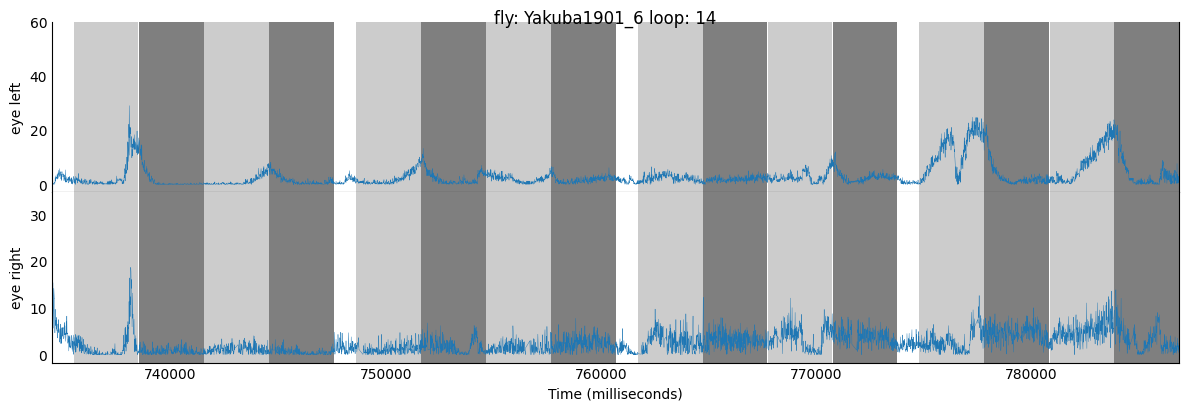

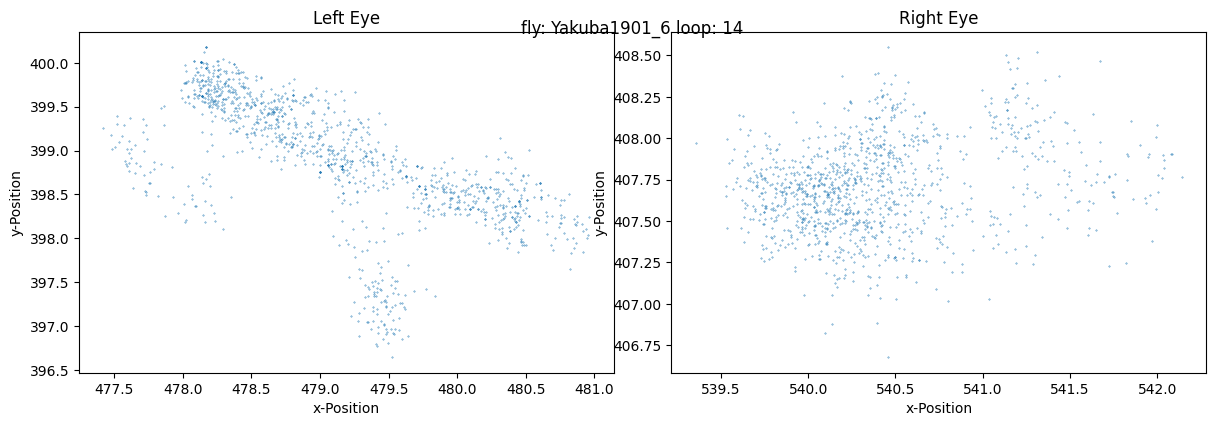

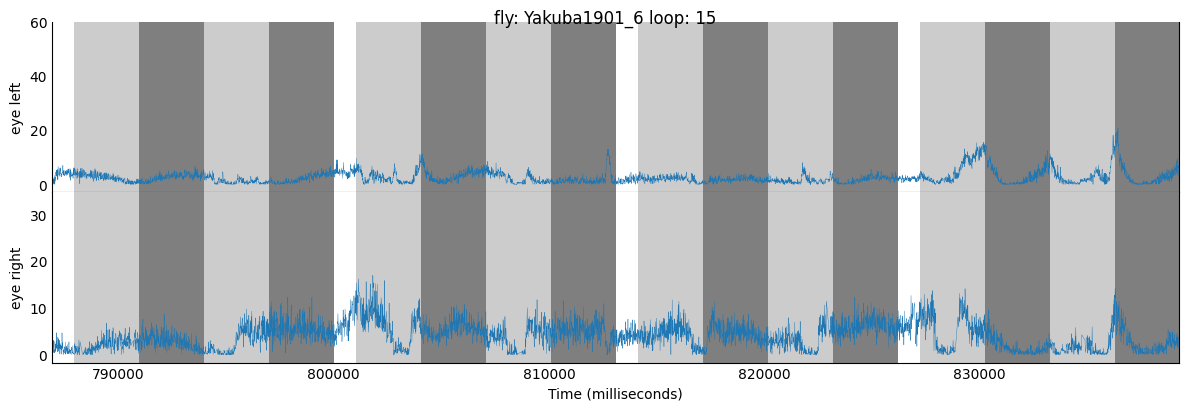

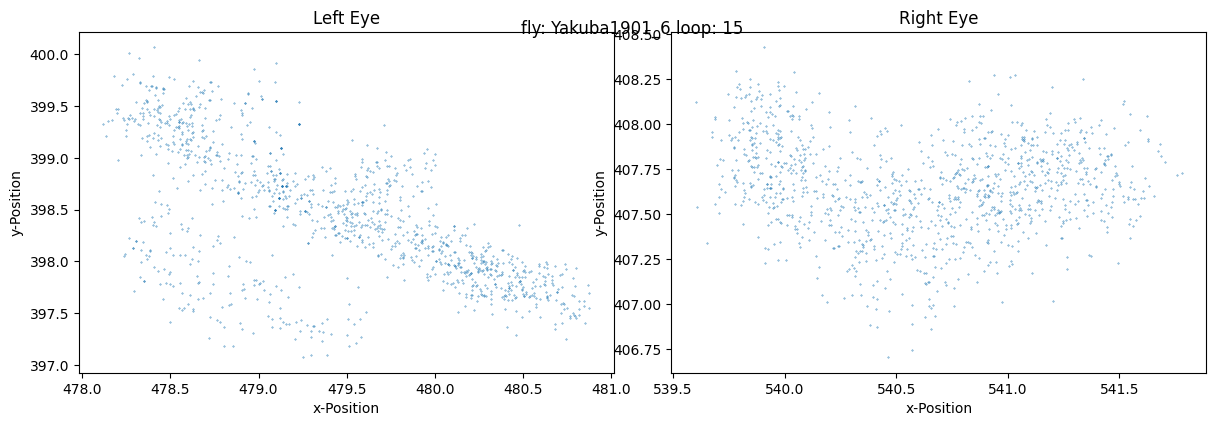

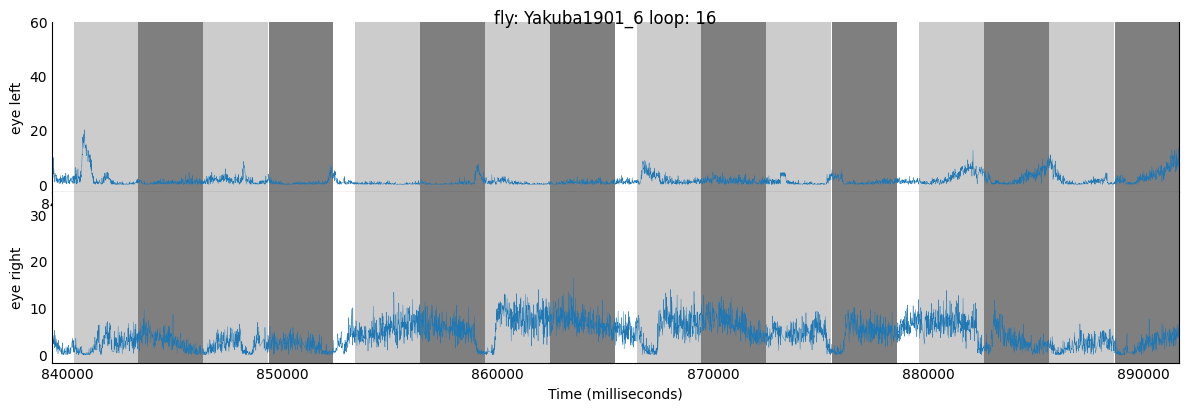

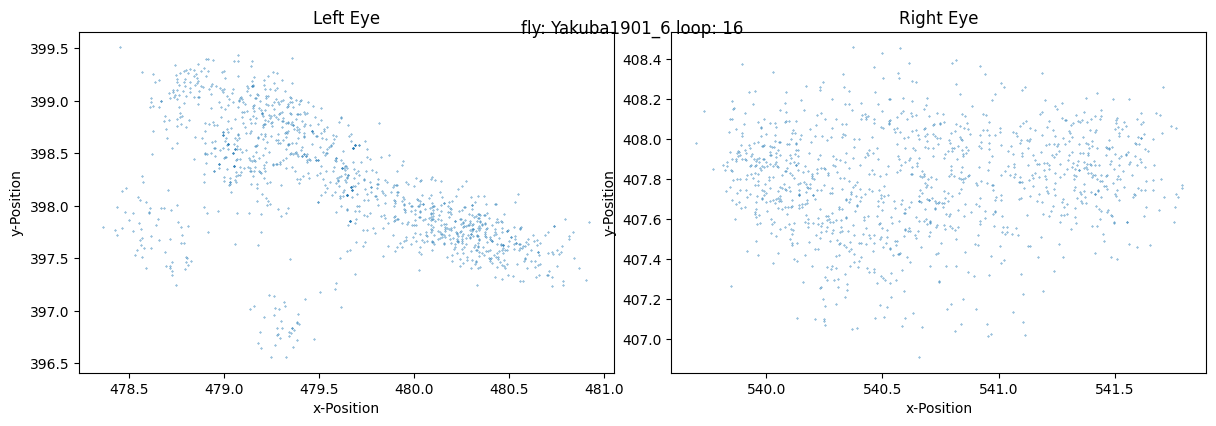

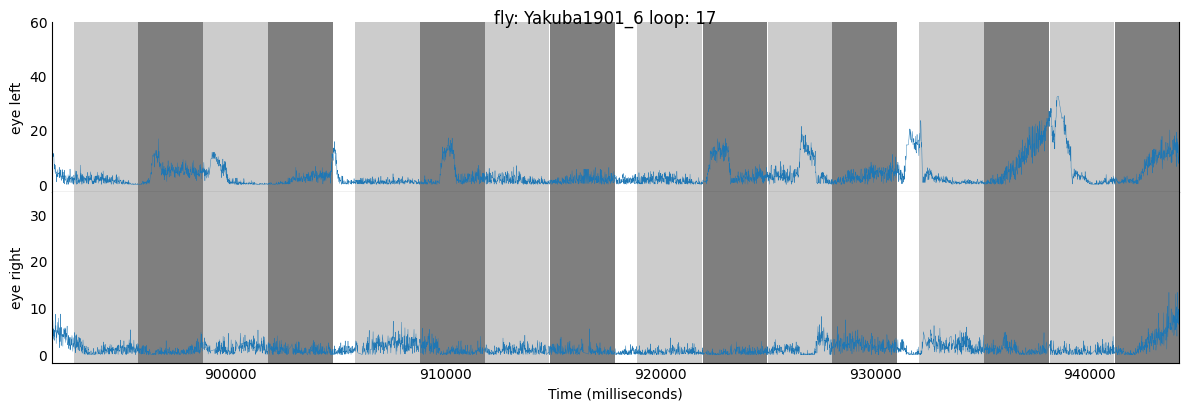

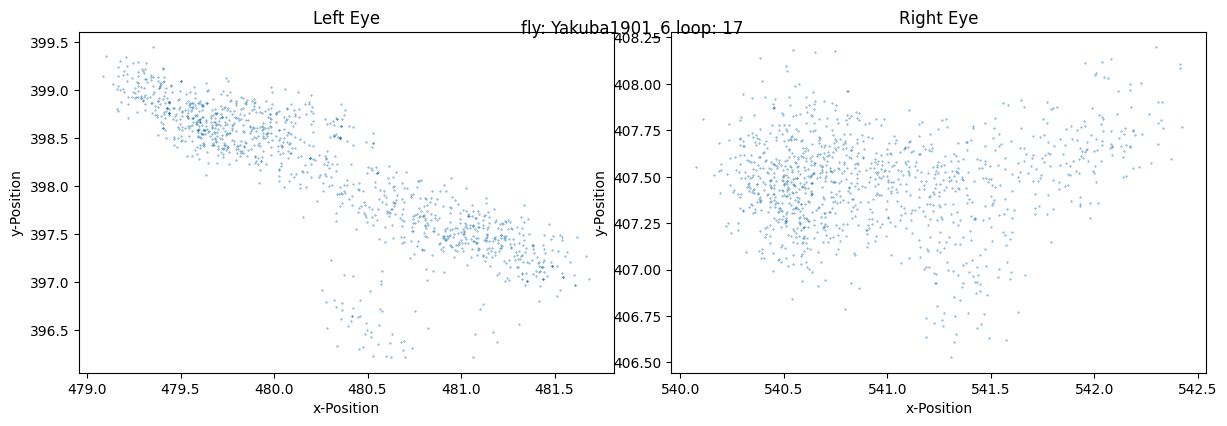

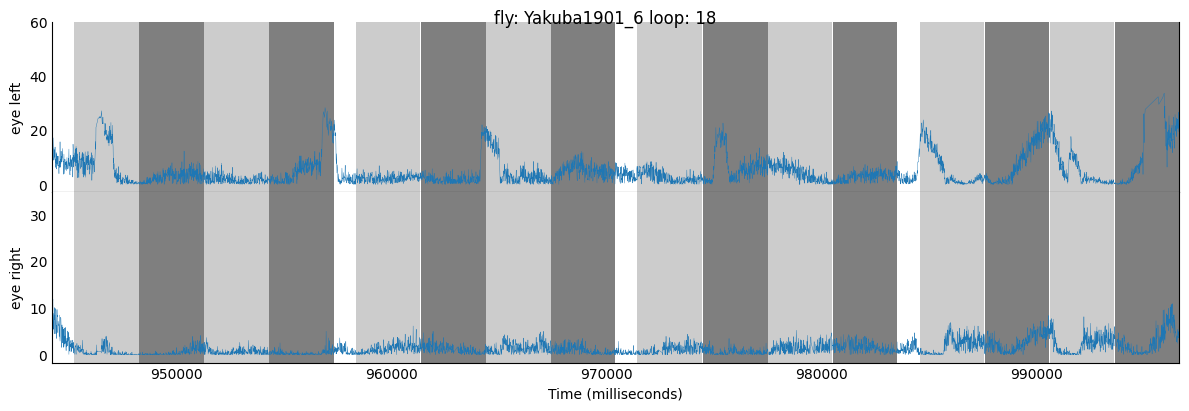

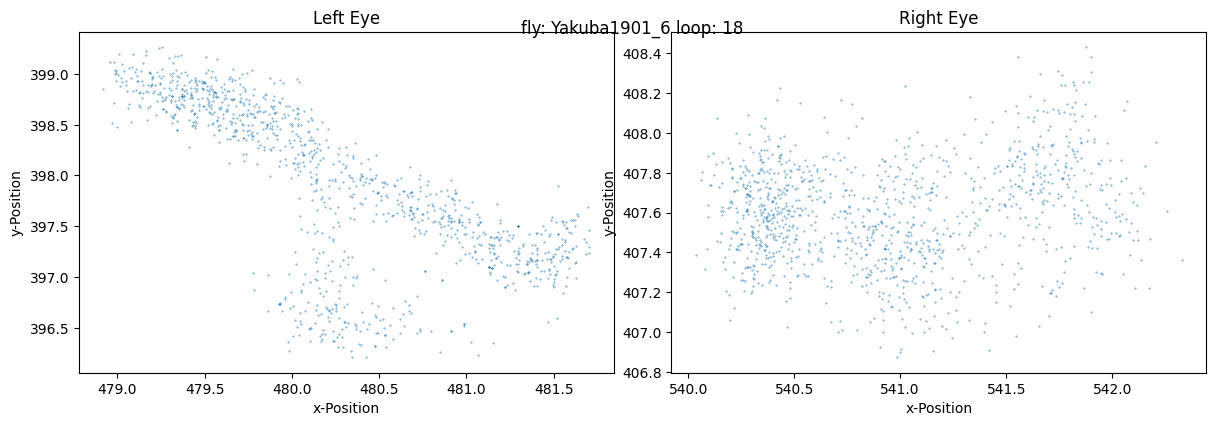

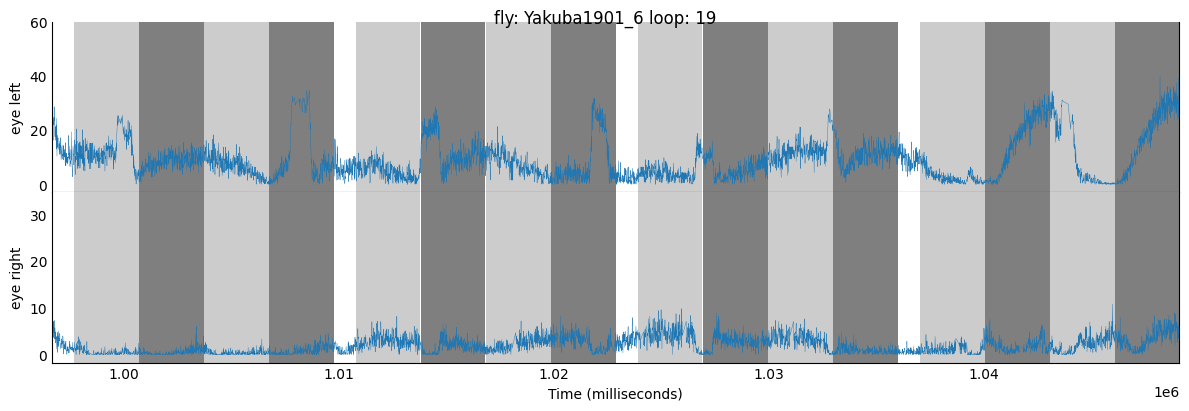

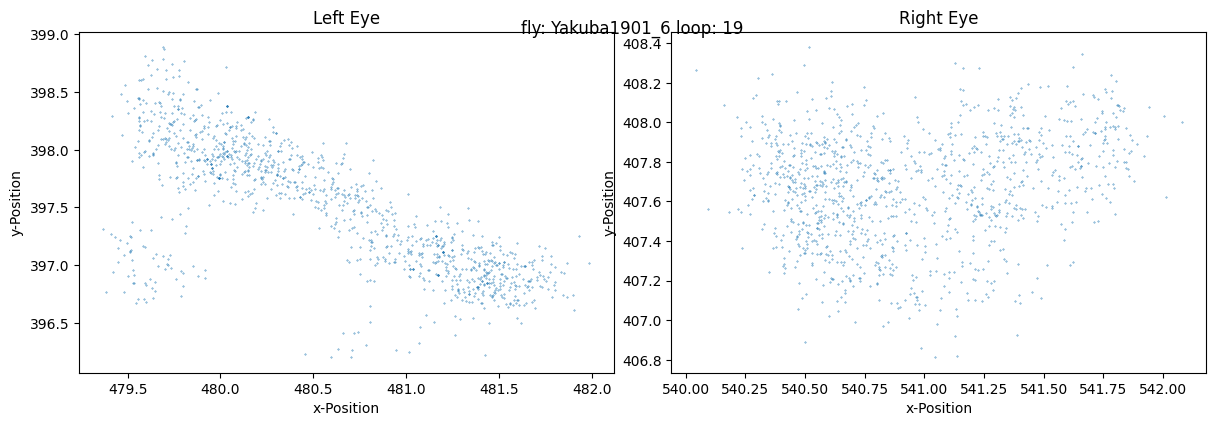

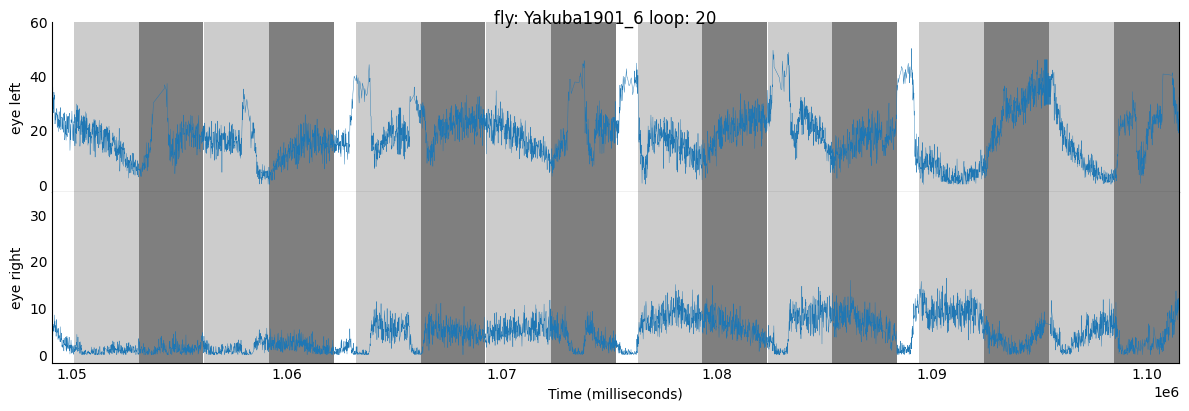

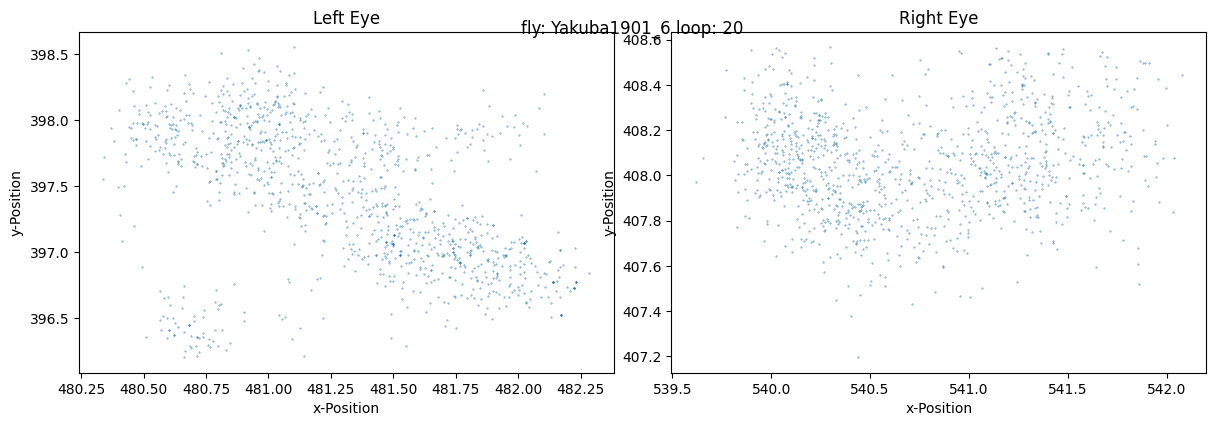

In [106]:
def config_subplot(subplot, ylabel=None, xlabel=None, xlim=None, ylim = None):
    subplot.set_ylabel(ylabel)
    subplot.tick_params(axis='y')
    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(True)
    subplot.spines['left'].set_visible(True)
    subplot.tick_params(axis='both', which='both', length=0)
    if xlabel is None:
        subplot.set_xticks([])
        subplot.spines['bottom'].set_visible(False)
    else:
        subplot.set_xlabel(xlabel)
    if ylim is not None:
        subplot.set_ylim(ylim[0], ylim[1])
    if xlim is not None:
        subplot.set_xlim(xlim[0], xlim[1])
    
    for index, side in df_Stimulus[(df_Stimulus['Event'] == 'side')].iterrows():
        alpha = 0.2 if side['ID']%2 == 0 else 0.5
        subplot.axvspan(side['Start_ms'], side['End_ms'], facecolor='0', alpha=alpha, zorder=-100)

loops = range(0,21)

df_no_outliers_RE = remove_outliers(df_RE)
RE_pupil_overview = np.absolute(df_no_outliers_RE['pupil_x']-np.mean(df_no_outliers_RE['pupil_x']))*np.absolute(df_no_outliers_RE['pupil_y']-np.mean(df_no_outliers_RE['pupil_y']))*10
df_no_outliers_LE = remove_outliers(df_LE)
LE_pupil_overview = np.absolute(df_no_outliers_LE['pupil_x']-np.mean(df_no_outliers_LE['pupil_x']))*np.absolute(df_no_outliers_LE['pupil_y']-np.mean(df_no_outliers_LE['pupil_y']))*10

for loop in loops:
    row = df_Stimulus[(df_Stimulus['Event'] == 'loop') & (df_Stimulus['ID'] == loop)]
    time_start = row['Start_ms'].iloc[0]
    time_end = row['End_ms'].iloc[0]
    
    # Create a figure with four vertically stacked subplots
    fig, axs = plt.subplots(2, 1, figsize=(12, 4), sharex=False)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    
    i = 0
    config_subplot(axs[i], ylabel='eye left' , xlabel='Time (milliseconds)', xlim=[time_start, time_end])
    axs[i].plot(df_no_outliers_LE['time_stimuli'], LE_pupil_overview, label='pupil_x', linewidth=0.3)

    i = 1
    config_subplot(axs[i], ylabel='eye right' , xlabel='Time (milliseconds)', xlim=[time_start, time_end])
    axs[i].plot(df_no_outliers_RE['time_stimuli'], RE_pupil_overview, label='pupil_x', linewidth=0.3)

    plt.suptitle(f'fly: {fly} loop: {loop}')
    
    # Show the plot
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=False)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)

    df_no_outliers_LE_phase_3 = df_no_outliers_LE[
    (df_no_outliers_LE['stimuli_side'].notna()) &
    (df_no_outliers_LE['stimuli_loop'] == loop) &
    (df_no_outliers_LE['stimuli_phase'] == 3)] 

    i = 0
    axs[i].scatter(df_no_outliers_LE_phase_3['pupil_x'], df_no_outliers_LE_phase_3['pupil_y'], s=0.1)
    axs[i].title.set_text('Left Eye')
    axs[i].set_xlabel('x-Position')
    axs[i].set_ylabel('y-Position')

    df_no_outliers_RE_phase_3 = df_no_outliers_RE[
    (df_no_outliers_RE['stimuli_side'].notna()) &
    (df_no_outliers_RE['stimuli_loop'] == loop) &
    (df_no_outliers_RE['stimuli_phase'] == 3)]

    i = 1
    axs[i].scatter(df_no_outliers_RE_phase_3['pupil_x'], df_no_outliers_RE_phase_3['pupil_y'], s=0.1)
    axs[i].title.set_text('Right Eye')
    axs[i].set_xlabel('x-Position')
    axs[i].set_ylabel('y-Position')
    
    plt.suptitle(f'fly: {fly} loop: {loop}')
    plt.show()

remove :0
remove :0


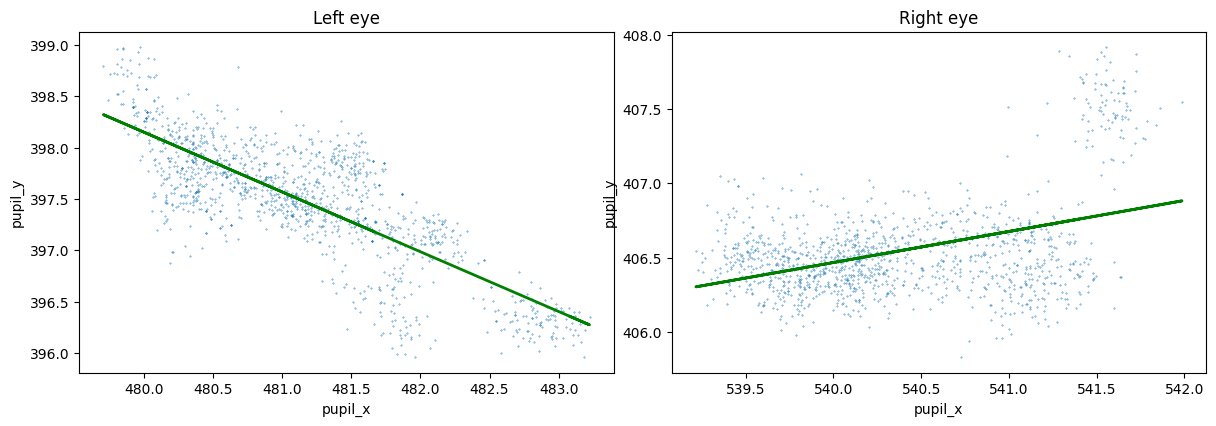

In [107]:
#the best loop from above - Has to be set!
left_ref_loops, left_ref_phases = [0],[3]
right_ref_loops, right_ref_phases = [2], [3]

#left_ref_loops, left_ref_phases = range(0,21), range(0,4)
#right_ref_loops, right_ref_phases = range(0,21), range(0,4)


fly_log['Ref_Loops_Left'], fly_log['Ref_Phases_Left'] = left_ref_loops, left_ref_phases
fly_log['Ref_Loops_Right'], fly_log['Ref_Phases_Right'] = right_ref_loops, right_ref_phases

def regress(x, y):

    # Find any nan values and delete that log both in x and y
    nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
    x = x[~nan_indices]
    y = y[~nan_indices]
    
    # Defining data for linear Regression and converting them into numpy arrays then into 2D array
    x = x.to_numpy().reshape((-1,1))
    y = y.to_numpy().reshape((-1,1))

    # Create the model & fit it 
    LinReg = LinearRegression().fit(x, y)
    
    # Get results
    sq = LinReg.score(x, y)
    slope = f"{LinReg.coef_}"
    slope = float(slope[+2:-2])
    interception = f"{LinReg.intercept_}"
    interception = float(interception[+1:-1])
    angle = np.degrees(np.arctan(slope))
    return slope, interception, angle, sq
    

ref_points_Left = df_LE[df_LE['stimuli_loop'].isin(left_ref_loops) & df_LE['stimuli_phase'].isin(left_ref_phases)]
ref_points_Left = remove_outliers(ref_points_Left, 8)
slope_LE, interception_LE, angle_LE, sq_LE = regress(ref_points_Left['pupil_x'], ref_points_Left['pupil_y'])

ref_points_Right = df_RE[df_RE['stimuli_loop'].isin(right_ref_loops) & df_RE['stimuli_phase'].isin(right_ref_phases)]
ref_points_Right = remove_outliers(ref_points_Right, 8)
slope_RE, interception_RE, angle_RE, sq_RE = regress(ref_points_Right['pupil_x'], ref_points_Right['pupil_y'])


fly_log['Transfo_Angle_Left'] = angle_LE
fly_log['Transfo_Angle_Right'] = angle_RE

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=False)
plt.tight_layout()
plt.subplots_adjust(hspace=0)

i = 0
config_EyePositionSubPlot(axs[i], ref_points_Left, x_axis='pupil_x', y_axis='pupil_y', title='Left eye')
b = slope_LE*ref_points_Left['pupil_x']+interception_LE
axs[i].plot(ref_points_Left['pupil_x'],b, 'g', linewidth=2)

i = 1
config_EyePositionSubPlot(axs[i], ref_points_Right, x_axis='pupil_x', y_axis='pupil_y', title='Right eye')
b = slope_RE*ref_points_Right['pupil_x']+interception_RE
axs[i].plot(ref_points_Right['pupil_x'],b, 'g', linewidth=2)

plt.show()

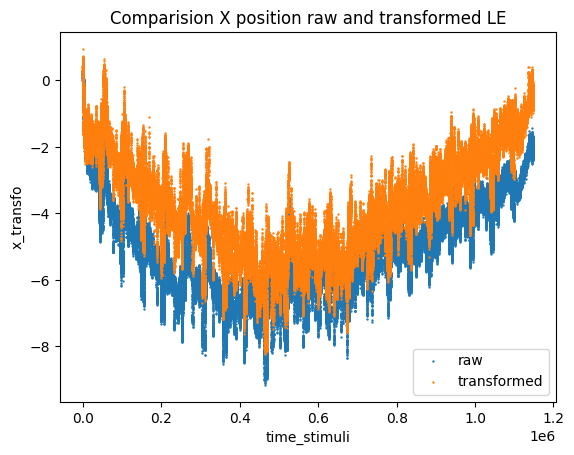

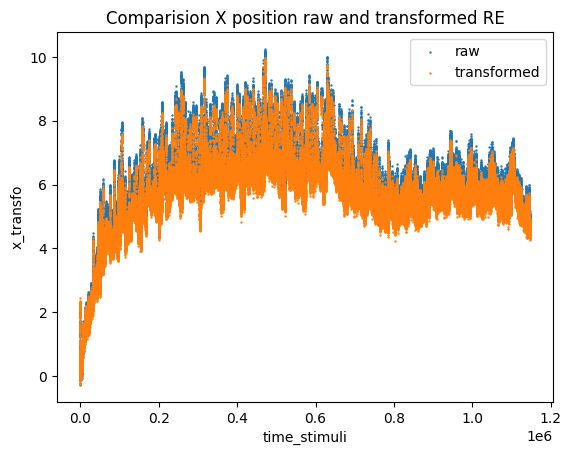

In [108]:
def config_EyePositionOverTimePlot(df, x_axis, y_axis, label):
    plt.scatter(df[x_axis],df[y_axis]-(df[y_axis][0]), s=0.5, label=label)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    
def transfo_axis(x, y, angle):
    x_tranfo = (x - x.min()) * np.cos(np.radians(-angle)) - (y - y.min()) * np.sin(np.radians(-angle)) 
    y_tranfo = (x - x.min()) * np.sin(np.radians(-angle)) + (y - y.min()) * np.cos(np.radians(-angle))
    return x_tranfo, y_tranfo

df_RE['x_transfo'], df_RE['y_transfo'] = transfo_axis(df_RE['pupil_x'], df_RE['pupil_y'], angle_RE)
df_LE['x_transfo'], df_LE['y_transfo'] = transfo_axis(df_LE['pupil_x'], df_LE['pupil_y'], angle_LE)


config_EyePositionOverTimePlot(df_LE, x_axis='time_stimuli', y_axis='pupil_x', label='raw')
config_EyePositionOverTimePlot(df_LE, x_axis='time_stimuli', y_axis='x_transfo', label='transformed')
plt.title('Comparision X position raw and transformed LE')
plt.show()

config_EyePositionOverTimePlot(df_RE, x_axis='time_stimuli', y_axis='pupil_x', label='raw')
config_EyePositionOverTimePlot(df_RE, x_axis='time_stimuli', y_axis='x_transfo', label='transformed')
plt.title('Comparision X position raw and transformed RE')
plt.show()

### Convert eye pixel positions into degrees, make them start a zero (substracted the median)

In [109]:
df_LE['pix_x'] = df_LE['x_transfo'] - df_LE['x_transfo'].median()
df_LE['pix_y'] = df_LE['y_transfo'] - df_LE['y_transfo'].median()

df_RE['pix_x'] = df_RE['x_transfo'] - df_RE['x_transfo'].median()
df_RE['pix_y'] = df_RE['y_transfo'] - df_RE['y_transfo'].median()

## Plot the eye angles over time

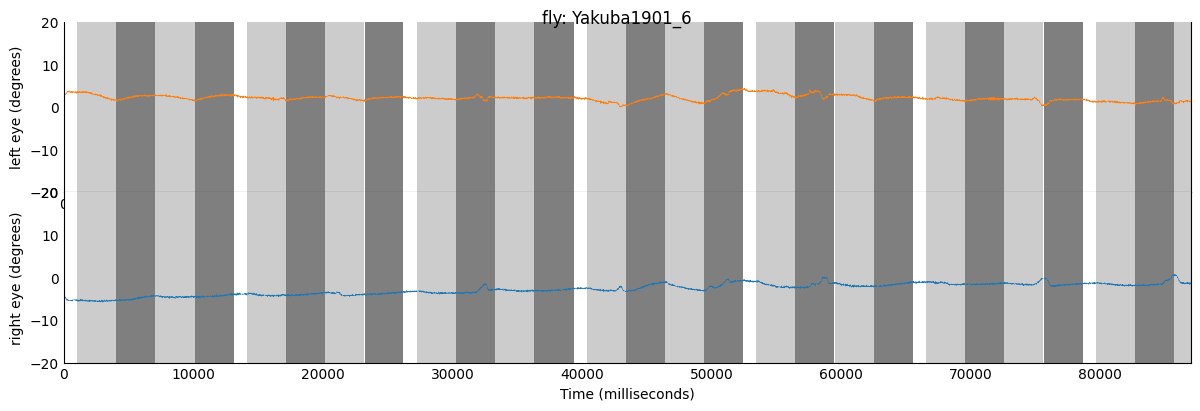

In [110]:
# Define the time range you want to display
time_start, time_end = 0, 87000


# Create a figure with four vertically stacked subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 4), sharex=False)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
y_lim = [-20,20]

i = 0
config_subplot(axs[i], ylabel='left eye (degrees)' , xlabel='Time (milliseconds)', xlim=[time_start, time_end], ylim=y_lim)
axs[i].plot(df_LE['time_stimuli'], df_LE['pix_x'], label='pix_x', color='tab:orange', linewidth=0.3)

i = 1
config_subplot(axs[i], ylabel='right eye (degrees)' , xlabel='Time (milliseconds)', xlim=[time_start, time_end], ylim=y_lim)
axs[i].plot(df_RE['time_stimuli'], df_RE['pix_x'], label='pix_x', color='tab:blue', linewidth=0.3)

# Set title for the entire figure
plt.suptitle(f'fly: {fly}')

# Show the plot
plt.show()

# Save .csv and Save the Stumulus Phase Used to Adjust the X-Axis 

In [111]:
df_Stimulus.to_csv(os.path.join(output_directory_path, fly + '_Stimulus.csv'), index=False)
df_LE.to_csv(os.path.join(output_directory_path, fly + '_LE.csv'), index=False)
df_RE.to_csv(os.path.join(output_directory_path, fly + '_RE.csv'), index=False)
pd.DataFrame([fly_log]).to_csv(os.path.join(output_directory_path, fly + '_Log.csv'), index=False)

with open(Ref_stimulus_path, 'a', newline='') as csvfile:              # Open the CSV file in append mode
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow([fly, f"L_{left_ref_loops}_{left_ref_phases}", f"R_{right_ref_loops}_{right_ref_phases}"])    # Write the new row to the CSV file